In [1]:
"""
In this notebook , i get the attention example from official documentation.
Then i created utilities to print output at every step.
I print all tensors with line information and explanation.
"""

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data,summary_count)
        
    def get_summary(self,labels,show_data=False,summary_count=1):
        print("summary_count",summary_count,"   self.capacity ",self.capacity)
        count = 0
        for i in range(summary_count):
            print(i," ------------------------------------------------")
            for l in labels:
                label_data = self.tensor_datas.get(l)[i]
                print(l)
                if torch.is_tensor(label_data):
                    print( list(label_data.size() ) )
                if not show_data and not torch.is_tensor(label_data):
                    print(label_data)
                if show_data:    
                    print(label_data)

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [56]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('D:/data6/torchdata/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [161]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [162]:
#input_lang, output_lang, pairs = readLangs('eng', 'deu', False)



In [164]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #print("pair[0]",pair)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je te laisse partir .', 'i m letting you go .']


In [103]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        step_logger.add_info(input,"EncoderRNN forward input")
        
        embedded = self.embedding(input).view(1, 1, -1)
        step_logger.add_info(embedded,"EncoderRNN forward embedded")
        
        output = embedded
        output, hidden = self.gru(output, hidden)
        
        step_logger.add_info(output,"EncoderRNN forward output")
        step_logger.add_info(hidden,"EncoderRNN forward hidden")
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [115]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        print("hidden_size, output_size,  max_length",hidden_size, output_size, max_length)

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    #decoder_hidden = encoder_hidden   #   
    #decoder_output, decoder_hidden, decoder_attention = decoder(
    #decoder_input, decoder_hidden, encoder_outputs)
    #decoder_attentions[di] = decoder_attention.data
    #topv, topi = decoder_output.data.topk(1)
    #
    #
    #
    # embedded -> output of embedding layer of input,which is decoder_input
    # hidden -> decoder_hidden (initiated with encoder output)
    #attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
    #
    # attn_weights are concat  of decoder input and decoder hidden
    #
    #
    # encoder_outputs ->
    #attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
    #
    #      attention is matrix(attention) of decoder with encoder outputs
    #encoder outputs remain constant through cycle
    def forward(self, input, hidden, encoder_outputs):
        #[1, 1]
        #tensor([[0]])
        step_logger.add_info(input,"AttnDecoderRNN forward input(decoder_input)")
        #[1, 1, 16]    hidden_size = 16  
        #tensor([[[ 0.0447,  0.5378, -0.0131,  0.5139, -0.3820, -0.1825, -0.0179,
        #  -0.3962, -0.3650,  0.0386, -0.2046,  0.3334,  0.1709, -0.0601,
        #  -0.1882,  0.3011]]], grad_fn=<StackBackward>)
        #Initial decoder_hidden  is last encode_hidden  
        step_logger.add_info(hidden,"AttnDecoderRNN forward hidden(decoder_hidden)")
        #[10, 16]  max_length=10  hidden_size = 16  
        #***  For a sentence of length 10 16 hidden value as an output 
        #[[ 0.1894, -0.2005, -0.1883,  0.1276, -0.0846, -0.0100, -0.2162,  0.1455,
        #  0.0674, -0.4827, -0.1173,  0.1991, -0.1955, -0.2934, -0.0482, -0.4623],
        #[ 0.3341, -0.1110, -0.2215,  0.1306, -0.0975,  0.1402,  0.1557, -0.1684,
        # -0.4491, -0.5662, -0.0173,  0.1988,  0.2005,  0.1026, -0.1635, -0.6204]
        #...........
        step_logger.add_info(encoder_outputs,"AttnDecoderRNN forward encoder_outputs(encoder_outputs)")
        
        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        #                                  2803        , 16
        embedded = self.embedding(input).view(1, 1, -1)
        #[1, 1, 16]
        #tensor([[[ 1.7158, -1.5114,  0.4700, -0.2104, -0.7919, -0.5094, -0.3325,
        #   0.9322,  0.0189, -0.2027, -0.7201,  0.9557,  1.2022,  0.9868,
        #  -0.0525, -0.0134]]], grad_fn=<ViewBackward>)
        step_logger.add_info(embedded,"AttnDecoderRNN forward embedded")
        
        embedded = self.dropout(embedded)
        #[1, 1, 16]  Some items are just made zero(droped out)
        #tensor([[[ 1.9064, -1.6793,  0.5222, -0.0000, -0.8799, -0.5660, -0.3694,
        #   1.0358,  0.0210, -0.2252, -0.8001,  1.0619,  0.0000,  0.0000,
        #  -0.0000, -0.0149]]], grad_fn=<MulBackward0>)
        step_logger.add_info(embedded,"AttnDecoderRNN forward embeddeddropout")
        
        #[1, 16]
        #tensor([[ 1.9064, -1.6793,  0.5222, -0.0000, -0.8799, -0.5660, -0.3694,  1.0358,
        #  0.0210, -0.2252, -0.8001,  1.0619,  0.0000,  0.0000, -0.0000, -0.0149]],
        step_logger.add_info(embedded[0],"AttnDecoderRNN  embedded[0]")
        #[1, 16]
        #tensor([[ 0.0447,  0.5378, -0.0131,  0.5139, -0.3820, -0.1825, -0.0179, -0.3962,
        # -0.3650,  0.0386, -0.2046,  0.3334,  0.1709, -0.0601, -0.1882,  0.3011]],
        #grad_fn=<SelectBackward>)
        step_logger.add_info(hidden[0],"AttnDecoderRNN  hidden[0]")

        torch_cat = torch.cat((embedded[0], hidden[0]), 1)
        #[1, 32]
        #tensor([[ 1.9064, -1.6793,  0.5222, -0.0000, -0.8799, -0.5660, -0.3694,  1.0358,
        #  0.0210, -0.2252, -0.8001,  1.0619,  0.0000,  0.0000, -0.0000, -0.0149,
        #  0.0447,  0.5378, -0.0131,  0.5139, -0.3820, -0.1825, -0.0179, -0.3962,
        # -0.3650,  0.0386, -0.2046,  0.3334,  0.1709, -0.0601, -0.1882,  0.3011]],
        #grad_fn=<CatBackward>)
        step_logger.add_info(torch_cat,"AttnDecoderRNN torch_cat")
        
        #nn.Linear(self.hidden_size * 2, self.max_length)
        #          hidden_size * 2 , 10    
        torch_attn = self.attn(torch_cat)
        #[1, 10]
        #tensor([[ 0.0317,  0.6561, -0.5269, -0.5180, -0.2896,  0.4543, -0.0107, -0.2258,
        # -0.3550,  0.2559]], grad_fn=<AddmmBackward>)
        step_logger.add_info(torch_attn,"AttnDecoderRNN torch_attn")
        
        attn_weights = F.softmax(torch_attn, dim=1)
        #[1, 10]
        #tensor([[0.1007, 0.1880, 0.0576, 0.0581, 0.0730, 0.1537, 0.0965, 0.0778, 0.0684,
        # 0.1260]], grad_fn=<SoftmaxBackward>)
        step_logger.add_info(attn_weights,"AttnDecoderRNN forward attn_weights")
        
        #attn_weights = [1, 10]  X  encoder_outputs = [10, 16]
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        #attn_applied = [1, 1, 16]
        #tensor([[[ 0.0787,  0.0078, -0.1058,  0.1634, -0.0812, -0.0201, -0.0229,
        #  -0.1296, -0.1419, -0.2153, -0.0839,  0.0634,  0.0621, -0.0313,
        #  -0.1015, -0.1873]]], grad_fn=<BmmBackward>)
        step_logger.add_info(attn_applied,"AttnDecoderRNN forward attn_applied")

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        #[1, 32]
        #tensor([[ 1.9064, -1.6793,  0.5222, -0.0000, -0.8799, -0.5660, -0.3694,  1.0358,
        #  0.0210, -0.2252, -0.8001,  1.0619,  0.0000,  0.0000, -0.0000, -0.0149,
        #  0.0787,  0.0078, -0.1058,  0.1634, -0.0812, -0.0201, -0.0229, -0.1296,
        # -0.1419, -0.2153, -0.0839,  0.0634,  0.0621, -0.0313, -0.1015, -0.1873]],
        #grad_fn=<CatBackward>)
        step_logger.add_info(output,"AttnDecoderRNN forward torch.cat")
        
        #self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        #                                     16   * 2 , 16
        output = self.attn_combine(output).unsqueeze(0)
        #[1, 1, 16]
        #tensor([[[ 0.4611, -0.3543,  0.0522,  0.1841, -0.0687,  0.3698, -0.2539,
        #  -0.0678,  0.2044,  0.1641,  0.2270, -0.0804,  0.2515,  0.9163,
        #   0.4080, -0.3230]]], grad_fn=<UnsqueezeBackward0>)
        step_logger.add_info(output,"AttnDecoderRNN forward attn_combine")

        output = F.relu(output)
        #[1, 1, 16]
        #tensor([[[0.4611, 0.0000, 0.0522, 0.1841, 0.0000, 0.3698, 0.0000, 0.0000,
        #  0.2044, 0.1641, 0.2270, 0.0000, 0.2515, 0.9163, 0.4080, 0.0000]]],
        #grad_fn=<ReluBackward0>)
        step_logger.add_info(output,"AttnDecoderRNN forward relu")
        
        #self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        #                       16   16
        output, hidden = self.gru(output, hidden)
        #[1, 1, 16]
        #tensor([[[-0.0450,  0.3120,  0.1570,  0.2884, -0.0724, -0.1919, -0.0849,
        #   0.0518, -0.3280,  0.0061, -0.2277,  0.1629,  0.1957, -0.1032,
        #  -0.0442,  0.2698]]], grad_fn=<StackBackward>)
        step_logger.add_info(output,"AttnDecoderRNN forward output")
        #[1, 1, 16]
        #tensor([[[-0.0450,  0.3120,  0.1570,  0.2884, -0.0724, -0.1919, -0.0849,
        #   0.0518, -0.3280,  0.0061, -0.2277,  0.1629,  0.1957, -0.1032,
        #  -0.0442,  0.2698]]], grad_fn=<StackBackward>)
        step_logger.add_info(hidden,"AttnDecoderRNN forward hidden")

        output = F.log_softmax(self.out(output[0]), dim=1)
        #[1, 2803]
        #tensor([[-8.1265, -8.0314, -7.9272,  ..., -7.9011, -8.0267, -7.9581]],
        #grad_fn=<LogSoftmaxBackward>)
        step_logger.add_info(output,"AttnDecoderRNN forward log_softmax")
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [140]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [141]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    step_logger.add_info(encoder_output,"train encoder_output")    

    decoder_input = torch.tensor([[SOS_token]], device=device)
                         
    step_logger.add_info(decoder_input,"train decoder_input")                             

    decoder_hidden = encoder_hidden

    use_teacher_forcing = False # True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            #values returning from attention : 
            # output, hidden, attn_weights
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)                         
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            #values returning from attention : 
            # output, hidden, attn_weights
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            step_logger.add_info(decoder_output,"train loop decoder_output")             
            topv, topi = decoder_output.topk(1)
            step_logger.add_info(topv,"train loop topv") 
            step_logger.add_info(topi,"train loop topi")                      
                                                      
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [142]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [143]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        #print("input_tensor",input_tensor.size())
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [144]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [145]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [146]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


hidden_size, output_size,  max_length 16 2803 10
1m 10s (- 16m 22s) (5000 6%) 3.5741
2m 41s (- 17m 31s) (10000 13%) 3.2916
4m 25s (- 17m 40s) (15000 20%) 2.9764
6m 32s (- 17m 59s) (20000 26%) 2.8257
8m 36s (- 17m 13s) (25000 33%) 2.7452
10m 44s (- 16m 6s) (30000 40%) 2.7011
18m 16s (- 20m 52s) (35000 46%) 2.6821
21m 12s (- 18m 33s) (40000 53%) 2.6144
22m 37s (- 15m 5s) (45000 60%) 2.6058
24m 1s (- 12m 0s) (50000 66%) 2.5650
25m 13s (- 9m 10s) (55000 73%) 2.5449
26m 20s (- 6m 35s) (60000 80%) 2.5307
27m 23s (- 4m 12s) (65000 86%) 2.4839
28m 30s (- 2m 2s) (70000 93%) 2.4622
29m 36s (- 0m 0s) (75000 100%) 2.4655


<Figure size 432x288 with 0 Axes>

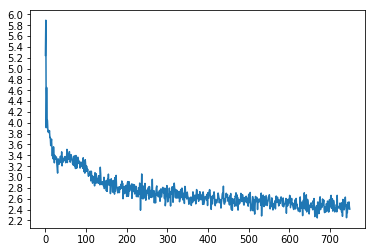

In [147]:
hidden_size = 16
step_logger =  StepLogger(8)

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [113]:
step_logger.get_default_summary()

summary_count 1    self.capacity  8
0  ------------------------------------------------
EncoderRNN forward input
[1]
EncoderRNN forward embedded
[1, 1, 16]
EncoderRNN forward output
[1, 1, 16]
EncoderRNN forward hidden
[1, 1, 16]
train encoder_output
[1, 1, 16]
train decoder_input
[1, 1]
AttnDecoderRNN forward input(decoder_input)
[1, 1]
AttnDecoderRNN forward hidden(decoder_hidden)
[1, 1, 16]
AttnDecoderRNN forward encoder_outputs(encoder_outputs)
[10, 16]
AttnDecoderRNN forward embedded
[1, 1, 16]
AttnDecoderRNN forward embeddeddropout
[1, 1, 16]
AttnDecoderRNN softmax embedded[0]
[1, 16]
AttnDecoderRNN softmax hidden[0]
[1, 16]
AttnDecoderRNN torch_cat
[1, 32]
AttnDecoderRNN torch_attn
[1, 10]
AttnDecoderRNN forward attn_weights
[1, 10]
AttnDecoderRNN forward attn_applied
[1, 1, 16]
AttnDecoderRNN forward torch.cat
[1, 32]
AttnDecoderRNN forward attn_combine
[1, 1, 16]
AttnDecoderRNN forward relu
[1, 1, 16]
AttnDecoderRNN forward output
[1, 1, 16]
AttnDecoderRNN forward hidden
[1, 1

In [114]:
step_logger.get_default_summary(True)

summary_count 1    self.capacity  8
0  ------------------------------------------------
EncoderRNN forward input
[1]
tensor([123])
EncoderRNN forward embedded
[1, 1, 16]
tensor([[[-0.9186,  0.2331, -0.0680, -0.5990, -0.3817,  0.5061, -0.1989,
           1.8396, -0.3258, -0.8583,  1.3717, -0.4374, -1.4738, -1.8829,
           0.3420,  0.8271]]], grad_fn=<ViewBackward>)
EncoderRNN forward output
[1, 1, 16]
tensor([[[ 0.1894, -0.2005, -0.1883,  0.1276, -0.0846, -0.0100, -0.2162,
           0.1455,  0.0674, -0.4827, -0.1173,  0.1991, -0.1955, -0.2934,
          -0.0482, -0.4623]]], grad_fn=<StackBackward>)
EncoderRNN forward hidden
[1, 1, 16]
tensor([[[ 0.1894, -0.2005, -0.1883,  0.1276, -0.0846, -0.0100, -0.2162,
           0.1455,  0.0674, -0.4827, -0.1173,  0.1991, -0.1955, -0.2934,
          -0.0482, -0.4623]]], grad_fn=<StackBackward>)
train encoder_output
[1, 1, 16]
tensor([[[ 0.0447,  0.5378, -0.0131,  0.5139, -0.3820, -0.1825, -0.0179,
          -0.3962, -0.3650,  0.0386, -0.2046, 

In [150]:
attn_decoder1

AttnDecoderRNN(
  (embedding): Embedding(2803, 16)
  (attn): Linear(in_features=32, out_features=10, bias=True)
  (attn_combine): Linear(in_features=32, out_features=16, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(16, 16)
  (out): Linear(in_features=16, out_features=2803, bias=True)
)

In [149]:
encoder1

EncoderRNN(
  (embedding): Embedding(4345, 16)
  (gru): GRU(16, 16)
)

In [148]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis sure de son succes .
= i am sure of his success .
< i m the to my . . <EOS>

> elles sont onereuses .
= they re expensive .
< they re sorry . <EOS>

> tu le fais de travers !
= you re doing it wrong !
< you re the to . . . <EOS>

> je suis ravi de faire votre connaissance .
= i m very pleased to meet you .
< i m going to to . . . <EOS>

> elle a promis qu elle allait m appeler .
= she s promised to give me a ring .
< she is sorry to than who . . <EOS>

> vous etes tres observateurs .
= you re very observant .
< you re very brave . <EOS>

> je suis plus petit que toi .
= i am shorter than you .
< i m very than you . <EOS>

> je suis content de vous voir ici .
= i m glad to see you here .
< i m glad to you you you . <EOS>

> je tire .
= i m shooting .
< i m sorry . <EOS>

> je suis dans la maison .
= i m at home .
< i m going of . . <EOS>



In [151]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")

In [154]:
print("output_words ",output_words)
print("attentions size",attentions.size())
print("attentions",attentions)

output_words  ['i', 'm', 'too', 'happy', '.', '<EOS>']
attentions size torch.Size([6, 10])
attentions tensor([[9.8322e-01, 1.6082e-03, 4.7352e-03, 2.0238e-03, 3.6615e-03, 9.0449e-04,
         5.5568e-04, 1.3942e-03, 7.7804e-04, 1.1200e-03],
        [9.7299e-01, 5.1014e-03, 2.9671e-03, 3.0094e-03, 2.5453e-03, 9.3975e-04,
         6.9732e-03, 7.6940e-04, 3.2432e-03, 1.4575e-03],
        [1.0251e-02, 9.5921e-03, 1.5292e-02, 1.7127e-01, 2.3938e-02, 7.0912e-01,
         3.2868e-03, 3.9264e-02, 1.5238e-02, 2.7495e-03],
        [5.3843e-04, 1.1203e-01, 1.2258e-02, 2.6260e-02, 2.5694e-02, 6.7608e-01,
         1.2475e-01, 1.6089e-02, 4.3585e-03, 1.9320e-03],
        [1.1638e-05, 1.5404e-02, 1.2174e-03, 1.2299e-03, 1.9193e-03, 2.3334e-02,
         9.4685e-01, 9.2392e-03, 6.9463e-04, 1.0239e-04],
        [4.8699e-04, 4.7092e-01, 4.0365e-02, 3.1106e-02, 4.5452e-02, 4.7909e-02,
         1.8375e-01, 8.0182e-02, 4.7309e-02, 5.2525e-02]])


In [155]:
attentions.numpy()

array([[9.83218849e-01, 1.60816626e-03, 4.73524956e-03, 2.02379981e-03,
        3.66151705e-03, 9.04488319e-04, 5.55677281e-04, 1.39416964e-03,
        7.78044923e-04, 1.11998513e-03],
       [9.72993970e-01, 5.10141626e-03, 2.96706776e-03, 3.00935330e-03,
        2.54530739e-03, 9.39749181e-04, 6.97322469e-03, 7.69399165e-04,
        3.24320933e-03, 1.45750050e-03],
       [1.02514941e-02, 9.59205069e-03, 1.52918687e-02, 1.71271533e-01,
        2.39375755e-02, 7.09117293e-01, 3.28684435e-03, 3.92637514e-02,
        1.52381603e-02, 2.74945563e-03],
       [5.38425229e-04, 1.12033442e-01, 1.22582773e-02, 2.62601022e-02,
        2.56942548e-02, 6.76084399e-01, 1.24751054e-01, 1.60894301e-02,
        4.35849605e-03, 1.93203473e-03],
       [1.16384717e-05, 1.54037075e-02, 1.21739181e-03, 1.22989039e-03,
        1.91934640e-03, 2.33338326e-02, 9.46847975e-01, 9.23920609e-03,
        6.94634975e-04, 1.02388913e-04],
       [4.86991281e-04, 4.70919192e-01, 4.03648168e-02, 3.11064273e-02,
   

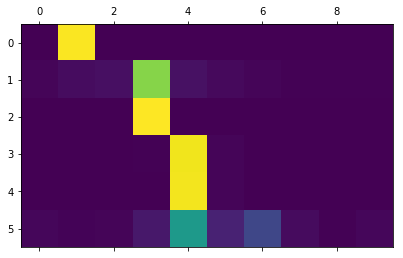

In [72]:

plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s afraid to as who . . <EOS>
output_words ['she', 's', 'afraid', 'to', 'as', 'who', '.', '.', '<EOS>']
input = elle est trop petit .
output = she is very busy . <EOS>
output_words ['she', 'is', 'very', 'busy', '.', '<EOS>']
input = je ne crains pas de mourir .
output = i m not here . . <EOS>
output_words ['i', 'm', 'not', 'here', '.', '.', '<EOS>']
input = c est un jeune directeur plein de talent .
output = he is a . . . . . . .
output_words ['he', 'is', 'a', '.', '.', '.', '.', '.', '.', '.']


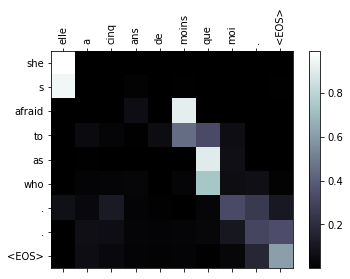

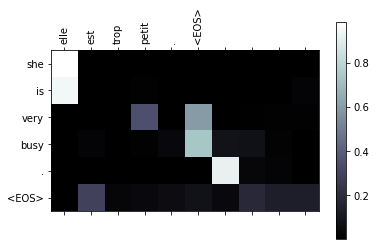

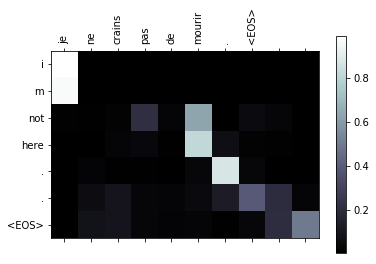

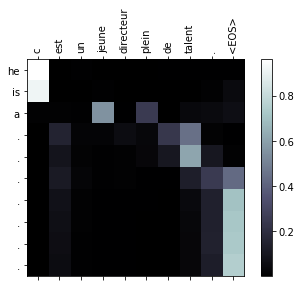

In [159]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")